Joao Filipe Costa da Quinta - TP2

In [1]:
import matplotlib.pyplot as plt
import math
import skimage
import cv2
import numpy as np
import copy
import skimage.metrics as metric
from scipy import signal
from skimage.measure import block_reduce
from os import listdir
from os.path import isfile, join
import random


print("Imports done")

Imports done


In [2]:
# random functions that are used all over the project
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
    
def affichage_rows_cols_images(rows, cols, images, labels, as_gray):
    rows = rows
    cols = cols
    axes = []
    fig = plt.figure(figsize=(6*rows,7*cols))
    for i in range(rows * cols):
        axes.append(fig.add_subplot(rows, cols, i + 1))
        if as_gray:
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(images[i])            
        plt.title(labels[i])
        plt.axis('off')
    fig.tight_layout()
    plt.show()

def loadImageGray(name):
    return cv2.imread(name,0)

def applyPermutation(image):
    return np.random.permutation(np.asarray([np.random.permutation(image[i]) for i in range(image.shape[0])]))

def computeRandomBlock(image):
    h,w = image.shape
    N,M = random.randint(h/8,h/2), random.randint(w/8,w/2)
    iN, iM = random.randint(0,h-N), random.randint(0,w-M)
    block = np.ones((h,w))
    for i in range(h):
        for j in range(w):
            if ((i >= iN) and (i < (iN + N))) and ((j >= iM) and (j < (iM + M))):
                block[i,j] = 0
    return block

def applyRandomBlock(image):
    blockImage_ = computeRandomBlock(image)
    return np.multiply(image, blockImage_)

def applyPermutationVector(image):
    imageVector = np.reshape(image,(image.shape[0]*image.shape[1]))
    permutation = np.random.permutation(np.arange(image.shape[0]*image.shape[1]))
    imagePermuted = np.asarray([imageVector[i] for i in permutation])
    imagePermuted = np.reshape(imagePermuted,(image.shape[0],image.shape[1]))
    return imagePermuted, permutation

def undoPermutation(permutedImage, permutation):
    permutedImageVector = np.reshape(permutedImage, (permutedImage.shape[0]*permutedImage.shape[1]))
    reconstructionImageVector = np.arange(permutedImage.shape[0]*permutedImage.shape[1])
    for i in range(permutation.shape[0]):
        reconstructionImageVector[permutation[i]] = permutedImageVector[i]
    return np.reshape(reconstructionImageVector, (permutedImage.shape[0], permutedImage.shape[1]))

def roundExcept0(v):
    if v < 0:
        return -1
    else:
        return 1

def MSE(X,Y):
    if X.shape == Y.shape:
        return np.sum([np.sum([(X[j,i]- Y[j,i])**2 for i in range(X.shape[1])]) for j in range(X.shape[0])]) / (X.shape[0]*X.shape[1])
    else:
        return 0

def PSNR(X,Y):
    a = 255
    mse = MSE(X,Y)
    if mse != 0:
        return 10 * np.log10(a**2/mse)
    else:
        return 0

def PSNR2(X,Y):
    a = 255
    sigma = np.sqrt(MSE(X,Y))
    return 10 * np.log10((a**2)/(sigma**2))

def gaussianNoiseValue(image ,v , mu, sigma):
    return np.asarray([[v * roundExcept0(np.random.normal(mu,sigma)) for i in range(image.shape[1])] for j in range(image.shape[0])])

### EXERCICE 1

image height :  512
image width :  512


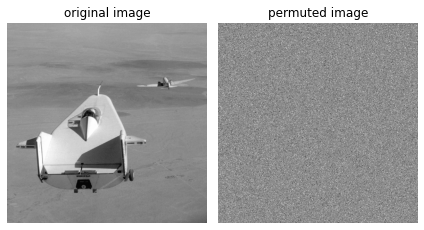

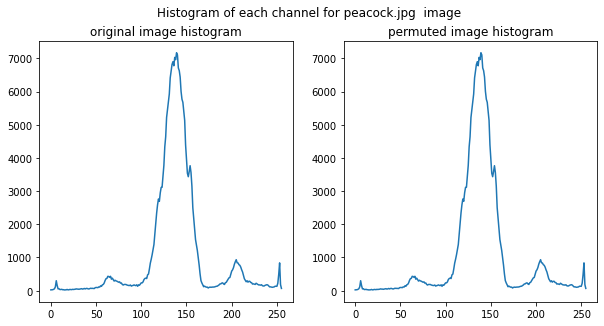

In [3]:
imageLift = loadImageGray("liftingbody.png")
height,width = imageLift.shape
print("image height : ", height)
print("image width : ", width)

permutedImage, permutation = applyPermutationVector(imageLift)
affichage_rows_cols_images(1, 2, [imageLift,permutedImage], ["original image", "permuted image"], True)

# extract histograms of both images
# cv2.calcHist() -> function input: image, which channel, mask, bin count, bin range values
originalImageHist = cv2.calcHist([imageLift],[0],None,[256],[0,256])
permutedImageHist = cv2.calcHist([permutedImage],[0],None,[256],[0,256])



# plot them
fig, axs = plt.subplots(1,2,figsize=(10,4.8))
fig.suptitle("Histogram of each channel for peacock.jpg  image")
axs[0].plot(originalImageHist)
axs[0].set_title('original image histogram')
axs[1].plot(permutedImageHist)
axs[1].set_title('permuted image histogram')
plt.show()


When we permute an image it becomes a complete mess, however, the histograms of the original image and the permuted image are exactly the same, which is normal, as histograms don't take into account position of the pixels, only the amount of each shade.

### EXERCICE 2

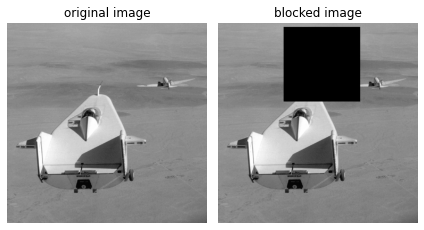

In [4]:
# compute block image with an implemented function, the block is of random size and position
imageLift = loadImageGray("liftingbody.png")
blockedImage = applyRandomBlock(imageLift)
affichage_rows_cols_images(1, 2, [imageLift, blockedImage], ["original image","blocked image"], True)

### EXERCICE 3

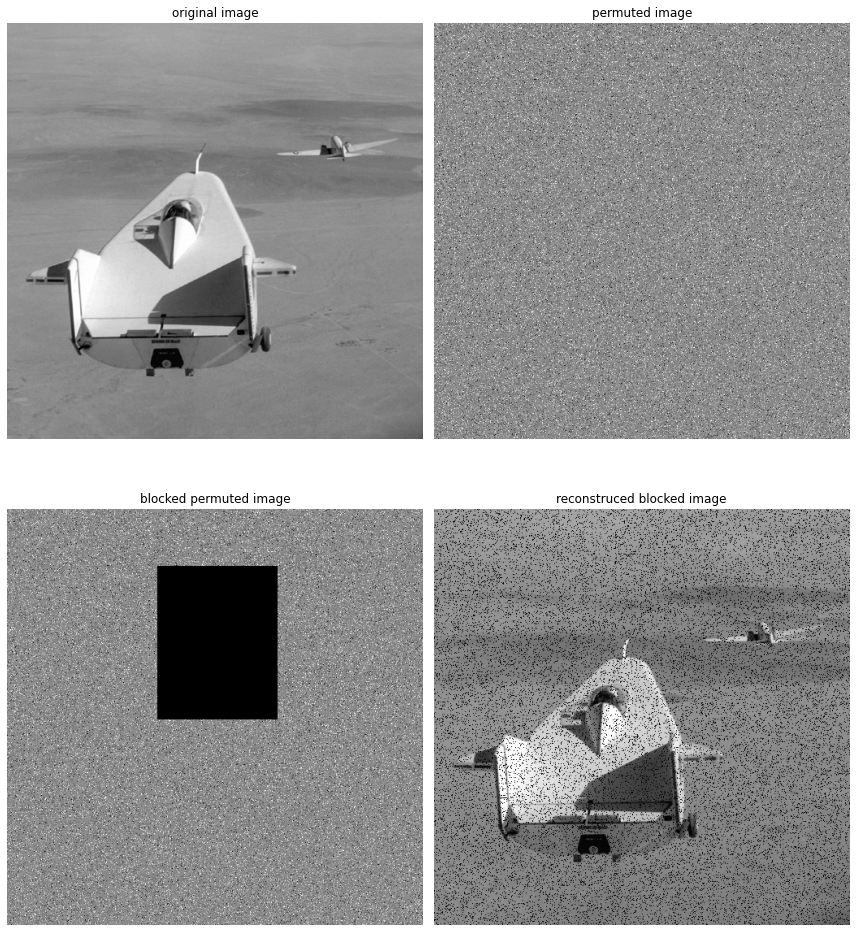

In [5]:
imageLift = loadImageGray("liftingbody.png")
permutedImage, permutation = applyPermutationVector(imageLift)
blockedPermutedImage = applyRandomBlock(permutedImage)
redoneBlockedPermutedImage = undoPermutation(blockedPermutedImage, permutation)

affichage_rows_cols_images(2, 2, [imageLift, permutedImage, blockedPermutedImage, redoneBlockedPermutedImage], ["original image","permuted image", "blocked permuted image", "reconstruced blocked image"], True)

First of, I made it so that the block is at least 1/8 of the image, and at most 1/4 of the image, so that the transformation is evidant, but the original image is still visible in the reconstruction.  
  
(step 1) we complitely mix the order of the pixels of the original image, by applying a permutation (top right)  
(step 2) compute a block image, and do a point to point multiplication with the permuted image (bottom left)  
(step 3) re-permuted the image that has a blocked area (bottom right)  
  
result -> every pixel is in the right location, however, their values are not the same as before, as some of them have been set to 0 !

### EXERCICE 4

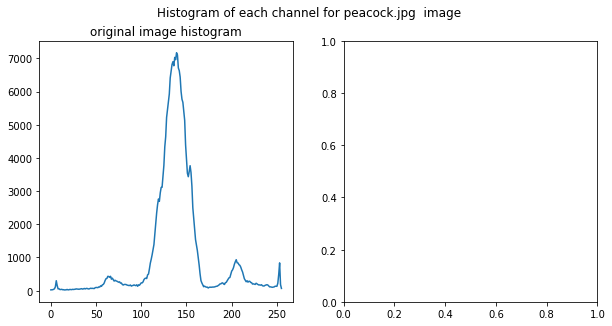

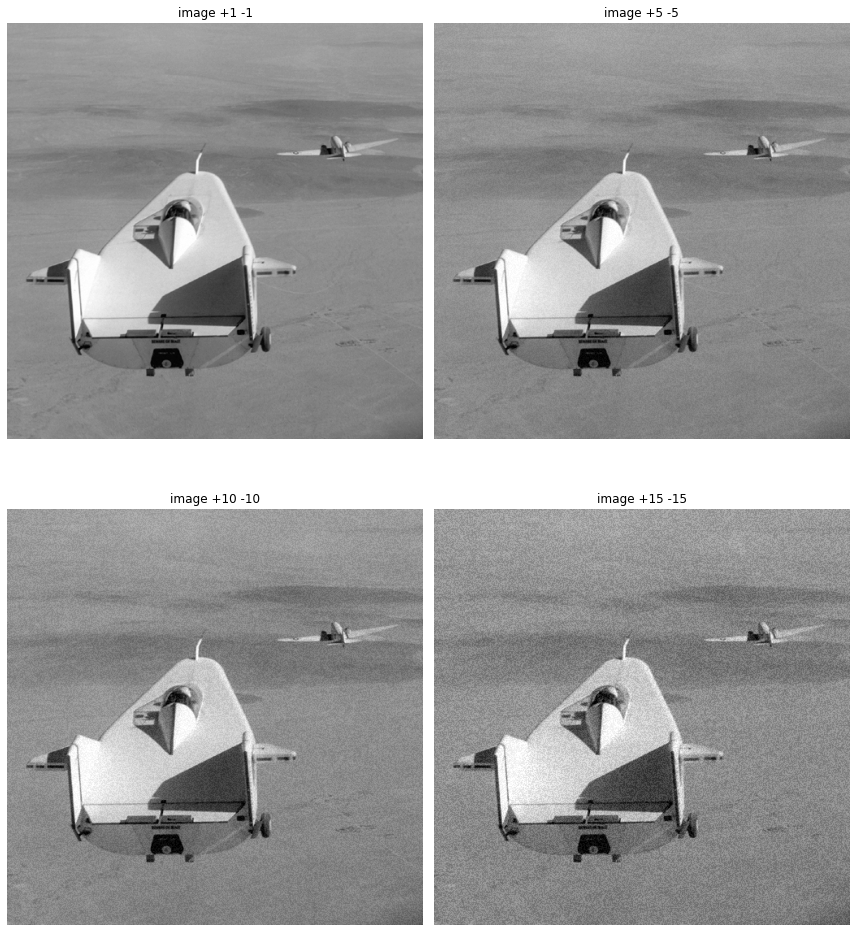

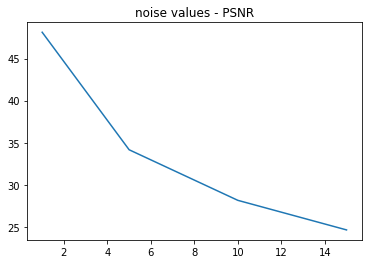

In [6]:
imageLift = loadImageGray("liftingbody.png")
noise_1 = gaussianNoiseValue(imageLift, 1 ,0, 1)
imageLift_1 = np.clip(imageLift + noise_1, 0, 255)
noise_5 = gaussianNoiseValue(imageLift, 5 ,0, 1)
imageLift_5 = np.clip(imageLift + noise_5, 0, 255)
noise_10 = gaussianNoiseValue(imageLift, 10 ,0, 1)
imageLift_10 = np.clip(imageLift + noise_10, 0, 255)
noise_15 = gaussianNoiseValue(imageLift, 15 ,0, 1)
imageLift_15 = np.clip(imageLift + noise_15, 0, 255)


imageLiftHist = cv2.calcHist([imageLift],[0],None,[256],[0,256])
#noiseLiftHist = cv2.calcHist([imageLift_1],[0],None,[256],[0,256])

fig, axs = plt.subplots(1,2,figsize=(10,4.8))
fig.suptitle("Histogram of each channel for peacock.jpg  image")
axs[0].plot(imageLiftHist)
axs[0].set_title('original image histogram')
#axs[1].plot(noiseLiftHist)
#axs[1].set_title('noisy +1 -1 image histogram')
plt.show()

images_noise = [imageLift_1, imageLift_5, imageLift_10, imageLift_15]
affichage_rows_cols_images(2, 2, images_noise, ["image +1 -1","image +5 -5", "image +10 -10", "image +15 -15"], True)

x = [1,5,10,15]
y = [PSNR2(imageLift,y) for y in images_noise]
plt.figure()
plt.title("noise values - PSNR")
plt.plot(x,y)
plt.show()

I couldnt debug my histogram bug, so it doesnt plot the second histogram.  
However, my guess is that the histograms of the original image and the one from the noisy image are almost the same!  
  
As expected, the higher your noise is, the lower your PSNR is !

### CLASSICAL CRYPTOGRAPHY
-> other file

### BASIC DATA HIDING

In [7]:
def hideImage(C_,S):
    C = np.copy(C_)
    if C.shape == S.shape:
        for i in range(C.shape[0]):
            for j in range(C.shape[1]):
                cBinaryR = np.binary_repr(C[i,j,0], width=8)# cover red
                cBinaryG = np.binary_repr(C[i,j,1], width=8)# cover green
                cBinaryB = np.binary_repr(C[i,j,2], width=8)# cover blue
                sBinaryR = np.binary_repr(S[i,j,0], width=8)# secret red
                sBinaryG = np.binary_repr(S[i,j,1], width=8)# secret green
                sBinaryB = np.binary_repr(S[i,j,2], width=8)# secret blue
                cBinaryR = cBinaryR[:5] + sBinaryR[:3]# new red channel value
                cBinaryG = cBinaryG[:6] + sBinaryB[:2]# new green channel value
                cBinaryB = cBinaryB[:3] + sBinaryG[:5]# new blue channel value
                C[i,j,0] = int(cBinaryR,2)   
                C[i,j,1] = int(cBinaryG,2)
                C[i,j,2] = int(cBinaryB,2)      
        return C
    else:
        return False

def recoverImage(C):
    re = np.copy(C)
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            re[i,j,0] = int(np.binary_repr(C[i,j,0], width=8)[5:] + '00000',2)
            re[i,j,1] = int(np.binary_repr(C[i,j,2], width=8)[3:] + '000',2)
            re[i,j,2] = int(np.binary_repr(C[i,j,1], width=8)[6:] + '000000',2)
    return re


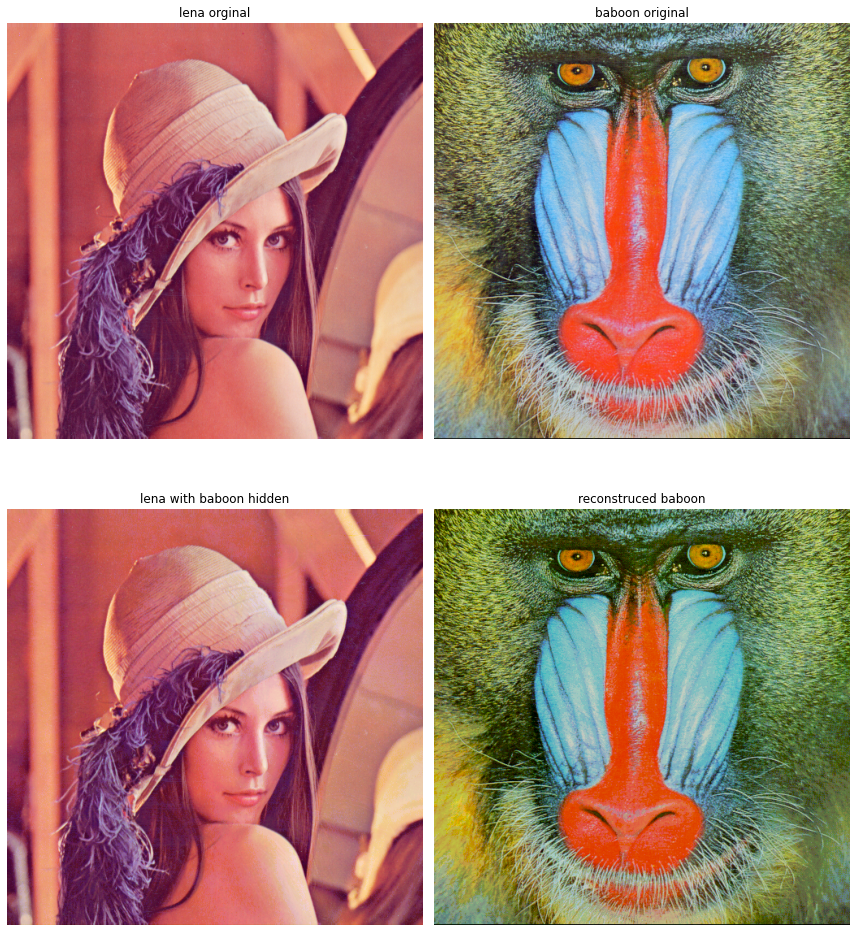

MSE between lena original (top left), and lena with hidden baboon (bottom left) : 83.36481094360352
MSE between baboon original (top right), and reconstructed baboon (bottom right) : 218.22515869140625


In [8]:
lena = cv2.cvtColor(cv2.imread("lena.png"), cv2.COLOR_BGR2RGB)
baboon = cv2.cvtColor(cv2.imread("baboon.png"), cv2.COLOR_BGR2RGB)
lenaBaboon = hideImage(lena,baboon)
baboonRe = recoverImage(lenaBaboon)
affichage_rows_cols_images(2, 2, [lena, baboon, lenaBaboon, baboonRe], ["lena orginal","baboon original","lena with baboon hidden", "reconstruced baboon"],False)
print("MSE between lena original (top left), and lena with hidden baboon (bottom left) :",MSE(lena, lenaBaboon))
print("MSE between baboon original (top right), and reconstructed baboon (bottom right) :",MSE(baboon, baboonRe))

First of, we take advantage that the HVS is less capable of visually notice high changes in blue channel, this means we can delete more information from the original image in the blue channel compare to the others  
Using the same logic, we choose to hide more green channel bits from the secret image.  
  
Finally, we keep MSB from the image to hide, and only lose LSB from the original image!